# Quiver Plot Tutorial

This demonstration will show how to re-project the NEMO velocities for quiver plotting.

NEMO velocities are usually calculated and saved in along grid i and j directions. This causes an issue when plotting velocities as vectors on a map where it is assumed that i and j velocities point eastwards and northwards but the grid is curvilinear.

There are additional isses when plotting quivers over the poles that we will cover.

The data we use here comes from a global model that has been cropped to the Arctic region. For Arctic contour plotting see `example_scripts/configuration_gallery/gc31_arctic_example_plot.py`

In [5]:
!pip install zarr xarray aiohttp requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Using cached yarl-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (268 kB)
  Using cached multidict-6.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached frozenlist-1.4.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (225 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import coast
import xarray as xr
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Usage of coast._utils.plot_util.velocity_grid_to_geo()

Plotting velocities with curvilinear grid and/or on a polar stereographic projection.

In [7]:
root = "../../../../"
# Paths to a single or multiple data files.
dn_files = root + "example_files/"
fn_nemo_dat_t = dn_files + "HadGEM3-GC31-HH_hist_thetao.nc"
fn_nemo_dat_u = dn_files + "HadGEM3-GC31-HH_hist_uo.nc"
fn_nemo_dat_v = dn_files + "HadGEM3-GC31-HH_hist_vo.nc"
fn_nemo_config_t = root + "config/gc31_nemo_grid_t.json"
fn_nemo_config_u = root + "config/gc31_nemo_grid_u.json"
fn_nemo_config_v = root + "config/gc31_nemo_grid_v.json"

# Set path for domain file if required.
fn_nemo_dom = dn_files + "gc31_domain.nc"

# Define output filepath (optional: None or str)
fn_out = './quiver_plot.png'

In [12]:
ds = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-dataset/n06.zarr")

In [13]:
ds

<xarray.Dataset>
Dimensions:       (deptht: 75, time_counter: 696, y: 3059, x: 4322)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(577, 577), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(577, 577), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1958-01-16T12:00:00 ... 2015-...
Dimensions without coordinates: y, x
Data variables: (12/17)
    e3t           (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 5, 577, 577), meta=np.ndarray>
    mldkz5        (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    mldr10_1      (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    potemp        (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 5, 577, 577), meta=np.ndarray>
    rsntds        (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    salin         (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 5, 577, 577), meta=np.ndarray>
    ...            ...
    sst           (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    taum          (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    tohfls        (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    tossq         (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    wfo           (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    zossq         (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:  80
    DOMAIN_size_global:   [4322, 3059]
    conventions:          CF-1.1
    description:          ocean T grid variables
    ibegin:               1
    jbegin:               1
    name:                 ORCA0083-N06_1m_19580101_19581231
    ni:                   4322
    nj:                   39
    production:           An IPSL model
    timeStamp:            2014-Nov-25 21:17:06 GMT

In [14]:
# Read in multiyear data (This example uses NEMO data from a single file.)
nemo_data_t = coast.Gridded(fn_data=fn_nemo_dat_t,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_t,
                          ).dataset
nemo_data_u = coast.Gridded(fn_data=fn_nemo_dat_u,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_u,
                          ).dataset
nemo_data_v = coast.Gridded(fn_data=fn_nemo_dat_v,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_v,
                          ).dataset

Select surface u and v as an example:

In [15]:
nemo_data_u

<xarray.Dataset>
Dimensions:             (x_dim: 4320, y_dim: 600, z_dim: 75, bnds: 2, t_dim: 1,
                         vertices: 4)
Coordinates:
  * i                   (x_dim) int32 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * j                   (y_dim) int32 3004 3005 3006 3007 ... 3601 3602 3603
    latitude            (y_dim, x_dim) float32 ...
    depth_0             (z_dim, y_dim, x_dim) float64 0.0 0.0 0.0 ... 0.0 0.0
    longitude           (y_dim, x_dim) float32 ...
  * time                (t_dim) object 1950-01-16 00:00:00
Dimensions without coordinates: x_dim, y_dim, z_dim, bnds, t_dim, vertices
Data variables:
    lev_bnds            (z_dim, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bnds           (t_dim, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    u_velocity          (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(1, 6, 328, 393), meta=np.ndarray>
    vertices_latitude   (y_dim, x_dim, vertices) float64 dask.array<chunksize=(600, 864, 1), meta=np.ndarray>
    vertices_longitude  (y_dim, x_dim, vertices) float64 dask.array<chunksize=(600, 864, 1), meta=np.ndarray>
    bathymetry          (y_dim, x_dim) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    e1                  (y_dim, x_dim) float64 ...
    e2                  (y_dim, x_dim) float64 ...
    e3_0                (z_dim, y_dim, x_dim) float64 ...
    mask                (z_dim, y_dim, x_dim) int8 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            HighResMIP
    branch_method:          fixed historical forcing from 1950 was applied fo...
    branch_time_in_child:   0.0
    branch_time_in_parent:  10800.0
    creation_date:          2020-08-03T09:35:59Z
    ...                     ...
    history:                Wed Nov  8 16:35:15 2023: ncks -d j,3004,3603 uo_...
    institution_id:         NERC
    NCO:                    netCDF Operators version 4.7.5 (Homepage = http:/...
    institution:            Natural Environment Research Council, STFC-RAL, H...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NERC.HadGEM3...
    license:                CMIP6 model data produced by NERC is licensed und...

In [29]:
# Coarsen the data to make it run faster, also we don't need to plot the full resolution for such a wide area.
nemo_data_uc = nemo_data_u.coarsen(y_dim=20, x_dim=20).mean()
nemo_data_vc = nemo_data_v.coarsen(y_dim=20, x_dim=20).mean()
nemo_data_tc = nemo_data_t.coarsen(y_dim=20, x_dim=20).mean()

In [30]:
# Select specific data variables.
data_u = nemo_data_uc[["u_velocity"]]
data_v = nemo_data_vc[["v_velocity"]]

In [31]:
# Select one time step and surface currents
data_u = data_u.isel(t_dim=0, z_dim=0)
data_v = data_v.isel(t_dim=0, z_dim=0)

In [32]:
# Calculate speed
speed = ((data_u.to_array().values[0, :, :] ** 2 + data_v.to_array().values[0, :, :] ** 2) ** 0.5)

In [34]:
%time
# Calculate adjustment for the curvilinear grid
u_new, v_new = coast._utils.plot_util.velocity_grid_to_geo(
        nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
        data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], polar_stereo_cartopy_bug_fix=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


100%|██████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


In [21]:
import numpy as np

In [22]:
lon = nemo_data_tc.longitude.values
lat = nemo_data_tc.latitude.values

In [23]:
crs_wgs84 = ccrs.CRS("epsg:4326")
angle = np.zeros(lon.shape)

In [26]:
lat.shape

(60, 432)

In [47]:
print(np.nanmean(u_new), np.nanmean(v_new))
print(np.nanmean(u_pol), np.nanmean(v_pol))

0.011763337302941329 -0.001737064190932461
0.012646832138722253 -0.0009679117749928778


In [35]:
# Apply the CartoPy stereographic polar correction
# NOTE: This could have been applied automatically with `polar_stereo=True` in
# coast._utils.plot_util.velocity_grid_to_geo()

u_pol, v_pol = coast._utils.plot_util.velocity_polar_bug_fix(u_new, v_new, nemo_data_tc.latitude.values)

In [36]:
# Set things up for plotting North Pole stereographic projection

# Data projection
data_crs = ccrs.PlateCarree()
# Plot projection
mrc = ccrs.NorthPolarStereo(central_longitude=0.0)

Below shows the u and v velocities when plotted with and without adjustment.

The plot shows three cases: 1:no correction, 2:the NEMO grid correction, and 3:the NEMO grid correction with polar stereographic plot correction. We also plot the final corrected u and v velocities as streamlines.
- In case 1, the lower latitude velocities aren't too bad but become irregular further north as the grid lines deviate form lat and lon.
- In case 2, the irregularity still persists even with the grid correction. This is the result of a CartoPy bug which also worsens at high latitudes.
- In case 3, both corrections have been applied and the velocities quivers now align with the route of strong current speed as would be expected.

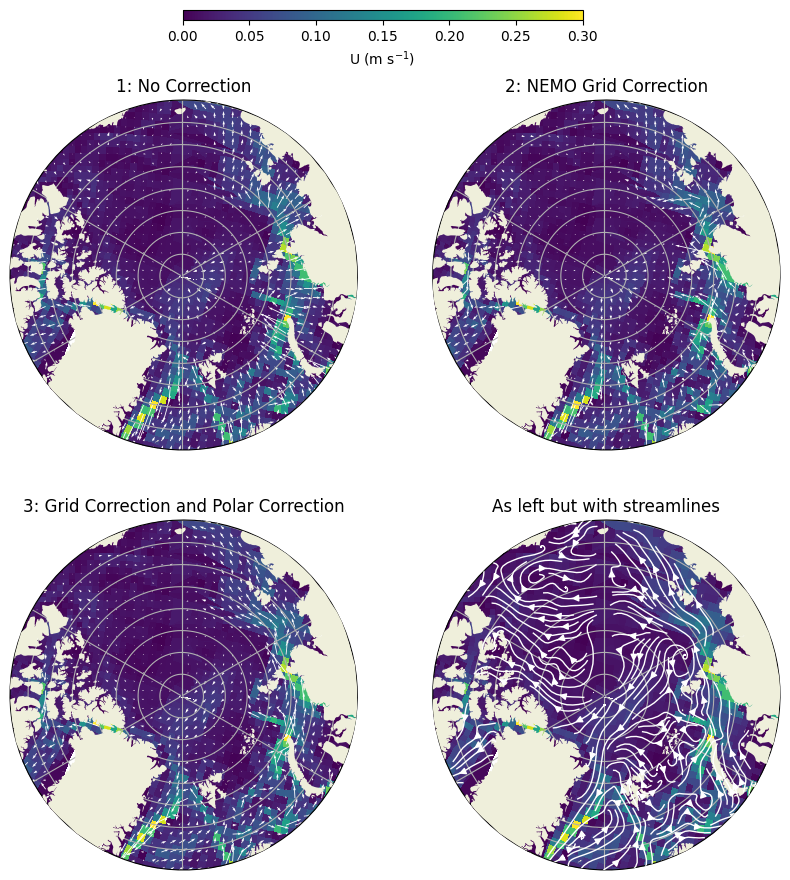

In [37]:
# Subplot axes settings
n_r = 2  # Number of subplot rows
n_c = 2  # Number of subplot columns
figsize = (10, 10)  # Figure size
subplot_padding = 0.5  # Amount of vertical and horizontal padding between plots
fig_pad = (0.075, 0.075, 0.1, 0.1)  # Figure padding (left, top, right, bottom)

# Labels and Titles
fig_title = "Velocity Plot"  # Whole figure title

# Create plot and flatten axis array
fig, ax = plt.subplots(n_r, n_c, subplot_kw={"projection": mrc}, sharey=True, sharex=True, figsize=figsize)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])


ax = ax.flatten()
for rr in range(n_r * n_c):
    ax[rr].add_feature(cfeature.LAND, zorder=100)
    ax[rr].gridlines()
    ax[rr].set_extent([-180, 180, 70, 90], crs=data_crs)
    coast._utils.plot_util.set_circle(ax[rr])


cs = ax[0].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[0].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[1].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[1].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_new, v_new, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[2].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[2].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[3].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[3].streamplot(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, transform=data_crs, linewidth=1, density=2, color='w', zorder=101)

ax[0].set_title('1: No Correction')
ax[1].set_title('2: NEMO Grid Correction')
ax[2].set_title('3: Grid Correction and Polar Correction')
ax[3].set_title('As left but with streamlines')

fig.colorbar(cs, cax=cax, orientation='horizontal')
cax.set_xlabel('U (m s$^{-1}$)')

#fig.tight_layout(w_pad=subplot_padding, h_pad=subplot_padding)
#fig.subplots_adjust(left=(fig_pad[0]), bottom=(fig_pad[1]), right=(1 - fig_pad[2]), top=(1 - fig_pad[3]))

plt.show()
fig.savefig(fn_out)